So, running [`add-filter-means-wavelength.py`](https://gitlab.astro.unige.ch/aalvarez/ph2ref/blob/master/add-filter-means-wavelength.py) gives us one fits file per modified `r` filter.

In [1]:
import os
from astropy.table import Table
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt

In [2]:
os.listdir('/home/aalvarez/Work/Data/coupon/')

['run_i10000_n30_correction',
 'fluxes_COSMOS15_test.fits',
 'run_i100_n30_correction',
 'fluxes_COSMOS15.fits',
 'fluxes.fits',
 'fluxes_COSMOS15_test_with_means_merged.fits',
 'fluxes_COSMOS15_test_with_means_r_shift0.fits',
 'nnpz.conf',
 'fluxes_COSMOS15_training.fits',
 'fluxes_COSMOS15_test_with_means.fits',
 'run_i100_n30_no_correction',
 'fluxes_COSMOS15_test_with_means_r.fits',
 'fluxes_COSMOS15_validation.fits']

The suffix tells the filter used. I have also patched nnpz to make sure from the output the proper columns are being used. For instance:

<pre><font color="#4E9A06">2018-04-25 09:11:18</font> <font color="#75507B">leela</font> <font color="#3465A4">__main__[19089]</font> <font color="#2E3436"><b>INFO</b></font> Running nnpz for fluxes_COSMOS15_test_with_means, filter r_skewing2 (using r_skewing2_mean for filter mean wavelength)
<font color="#4E9A06">2018-04-25 09:11:18</font> <font color="#75507B">leela</font> <font color="#3465A4">__main__[19089]</font> <font color="#2E3436"><b>INFO</b></font> Output will be /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means_r_skewing2.fits
<font color="#4E9A06">2018-04-25 09:11:18</font> <font color="#75507B">leela</font> <font color="#3465A4">__main__[19089]</font> <font color="#2E3436"><b>DEBUG</b></font> <font color="#4E9A06">Replacing r_obs with r_skewing2_obs</font>
<font color="#4E9A06">2018-04-25 09:11:18</font> <font color="#75507B">leela</font> <font color="#3465A4">__main__[19089]</font> <font color="#2E3436"><b>DEBUG</b></font> <font color="#4E9A06">Using PYTHONPATH: &quot;:/home/aalvarez/Work/Projects/NNPZ&quot;</font>
Target catalog photometric columns: [(&apos;u_obs&apos;, &apos;u_obs_err&apos;), (&apos;g_obs&apos;, &apos;g_obs_err&apos;), (&apos;r_skewing2_obs&apos;, &apos;r_skewing2_obs_err&apos;), (&apos;i_obs&apos;, &apos;i_obs_err&apos;), (&apos;z_obs&apos;, &apos;z_obs_err&apos;), (&apos;vis_obs&apos;, &apos;vis_obs_err&apos;), (&apos;Y_obs&apos;, &apos;Y_obs_err&apos;), (&apos;J_obs&apos;, &apos;J_obs_err&apos;), (&apos;H_obs&apos;, &apos;H_obs_err&apos;)]
Reading target catalog: /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
Using filters mean wavelength columns {&apos;r_skewing2&apos;: &apos;r_skewing2_mean&apos;}
Processing only first 100 objects from target catalog
Reading reference sample from /home/aalvarez/Work/Data/dc3/ReferenceSample...
Reading reference sample done
Using reference sample photometry from /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
Reference sample photometric bands: [&apos;u&apos;, &apos;g&apos;, &apos;r&apos;, &apos;i&apos;, &apos;z&apos;, &apos;vis&apos;, &apos;Y&apos;, &apos;J&apos;, &apos;H&apos;]
Using recomputed photometries for weight calculation
Finding neighbors... 100%   
Computing neighbor weights...100%   
Adding contributions to output...100%   
</pre>


So the configuration overriding is working fine (`r_skewing2_obs` instead of `r_obs`, and "Using filters mean wavelength columns" is also there with the proper values.).

The same script can merge all these intermediate results so we can have a look at them together easily. This can be done with the `--merge` flag.

In [3]:
with_correction = Table.read('/home/aalvarez/Work/Data/coupon/run_i100_n30_correction/fluxes_COSMOS15_test_with_means_merged.fits')

So we can see the columns include the median resulting from using different modified filters.

In [4]:
import itertools

In [5]:
all_filters = list(
    map(lambda a: 'r_{}{}'.format(*a), itertools.product(['shift', 'widening', 'skewing', 'softening'], range(10)))
)
all_filters.append('r')

In [6]:
def plot_errors(table):
    errors = {}
    for f_name in all_filters:
        if f'CoaddedPdz_50_{f_name}' in table.colnames:
            f_err = table[f'CoaddedPdz_50_{f_name}'] - table['z_true']
            errors[f_name] = f_err[np.isnan(f_err) == False]
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.grid(color='lightgrey', linestyle='-', linewidth=1)
    _ = plt.boxplot(list(errors.values()), 0, '', vert=False, labels=list(errors.keys()))

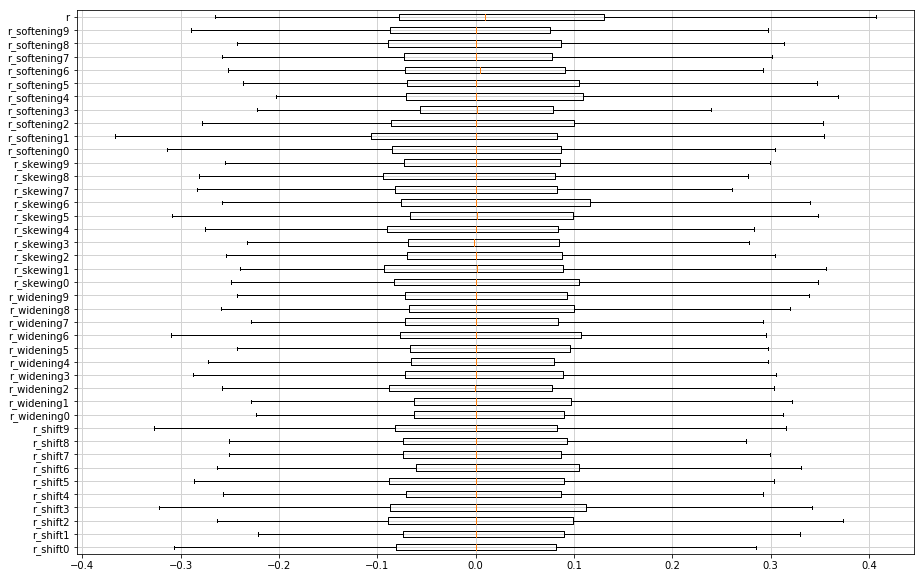

In [7]:
plot_errors(with_correction)

## Same run, not using the means
Nikos suggested to do the same run, but without correcting the filter shift. On y va.

In [8]:
without_correction = Table.read('/home/aalvarez/Work/Data/coupon/run_i100_n30_no_correction/fluxes_COSMOS15_test_with_means_merged.fits')

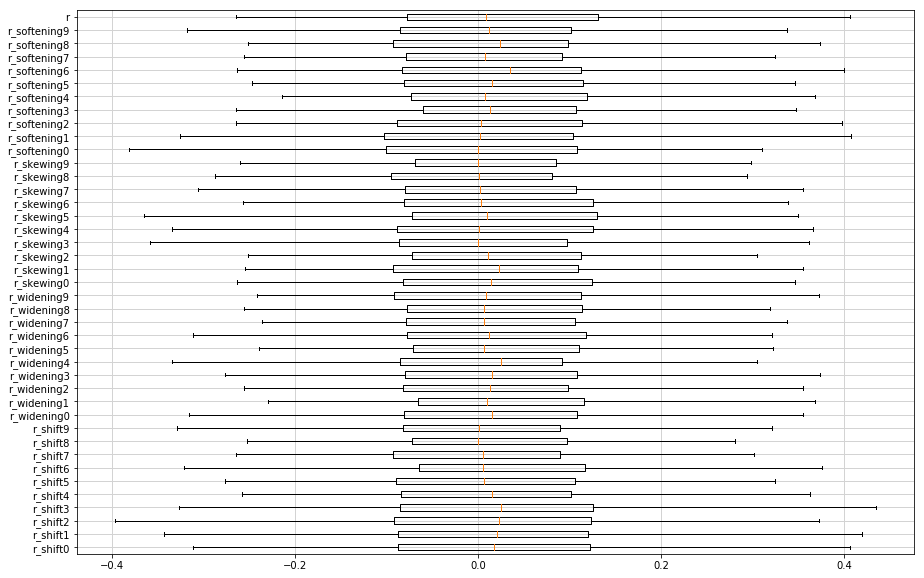

In [9]:
plot_errors(without_correction)

## 10,000 objects, compare only with r_shift_0
From the previous results, it is surprising the shifted versions align with 0, and not with `r`.

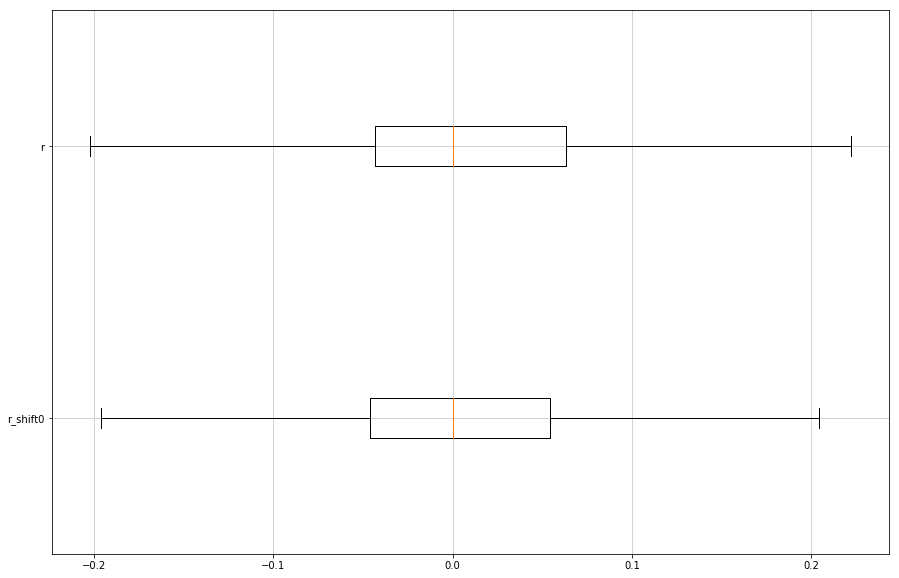

In [10]:
with_correction_10k = Table.read('/home/aalvarez/Work/Data/coupon/run_i10000_n30_correction/fluxes_COSMOS15_test_with_means_merged.fits')
plot_errors(with_correction_10k)

## Adendum

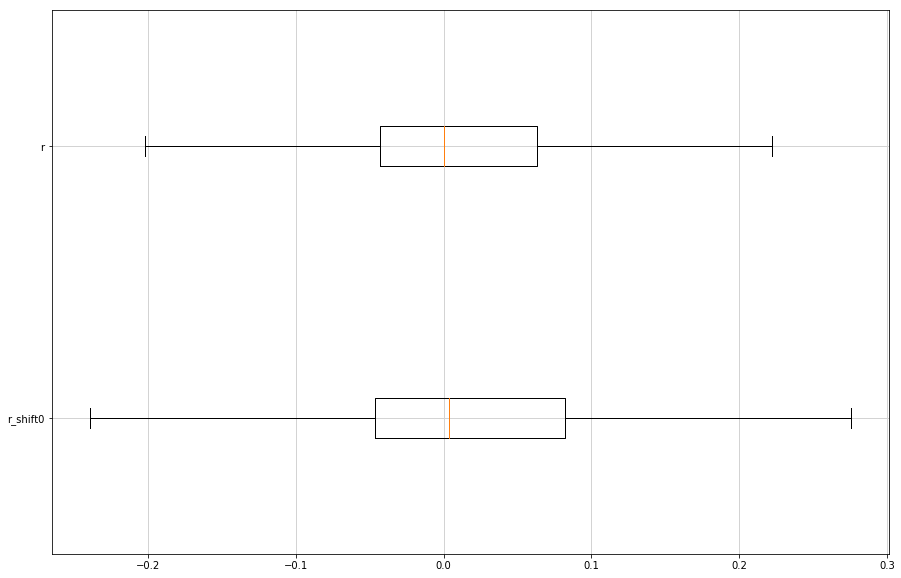

In [12]:
with_no_correction_10k = Table.read('/home/aalvarez/Work/Data/coupon/run_i10000_n30_no_correction/fluxes_COSMOS15_test_with_means_merged.fits')
plot_errors(with_no_correction_10k)